In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json
from datasets import load_dataset


dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])

In [4]:
import os 

def get_stats(train_name):
    train_accs_all = []
    perplexities_all = []


    ckpts = sorted([
    f for f in os.listdir("ckpts/"+train_name) if os.path.isdir(os.path.join("ckpts/"+train_name, f))
    ], key=lambda x: int(x.split('-')[1]))
    # print(ckpts)

    for ckpt in ckpts:
        try:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types5_seed2_temp0.8.npy")==0)
            
        except:
            train_correct = (np.load("ckpts/"+train_name+"/"+ckpt+ "/train_answer_types50_seed2_temp0.8.npy")==0)
        train_accs = train_correct.mean(axis=-1)
        train_accs_all.append(train_accs)
        
        perplexities = np.load("ckpts/"+train_name+"/"+ckpt+ "/train_perplexities.npy")
        perplexities_all.append(perplexities)
        
    train_accs_all = np.array(train_accs_all)
    perplexities_all = np.array(perplexities_all)
    
    test_accs_all = []

    for ckpt in ckpts:
        try:
            test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2.npy")==0)
        except:
            try:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types50_seed2_temp0.8.npy")==0)
            except:
                test_accs = (np.load("ckpts/"+train_name+"/"+ckpt+ "/test_answer_types5_seed2_temp0.8.npy")==0)
        test_accs_all.append(test_accs)

    test_accs_all = np.array(test_accs_all)
    
    return_dict = {}
    return_dict["train_accs_all"] = train_accs_all
    return_dict["perplexities_all"] = perplexities_all
    return_dict["test_accs_all"] = test_accs_all
    
    return return_dict




def get_ratios2(stats_dict, perp_threshold=-2.5):
    train_accs_all = stats_dict["train_accs_all"]
    perplexities_all = stats_dict["perplexities_all"]
    test_accs_all = stats_dict["test_accs_all"]
    
    memorization_mask = np.ones(train_accs_all.shape)*-1
    accs_all = np.ones(train_accs_all.shape)*-1
    
    for i in range(len(train_accs_all)):

        accs_all[i] =train_accs_all[i]
        
        memorization_mask[i] = (np.log(np.log((perplexities_all[i]))) >= perp_threshold)
    
    
    
    
    unmemorized_acc_cummax = np.array([(accs_all*memorization_mask)[:j+1].max(axis=0) for j in range(len(train_accs_all))])
    
    # print(unmemorized_acc_cummax.shape)
    # print(accs_all.shape)
    unmemorized_acc_cummax = (np.min([unmemorized_acc_cummax, accs_all], axis=0))
    unmemorized_acc_cummax_mean = unmemorized_acc_cummax.mean(axis=1)
    

    avg_test_acc = test_accs_all.mean(axis=1).mean(axis=1)
    
    
    
    return_dict = {}
    
    
    return_dict["unmemorized_acc_cummax"] = unmemorized_acc_cummax_mean
    return_dict["unmemorized_acc_cummax_all"] = unmemorized_acc_cummax

    return_dict["avg_test_acc"] = avg_test_acc
            
    return return_dict


In [4]:
import os

In [11]:
stats_dict = get_stats(f"gsm8k_orig_3epochs_shuffle1_lr2e-05_bs128")
ratio_dict = get_ratios2(stats_dict)

In [7]:
stats_dict_new = get_stats(f"gsm8k_amrith_1-2_threshold0.5_3epochs_lr2e-05_bs128")
ratio_dict_new = get_ratios2(stats_dict_new)

In [23]:
np.save("ckpts/gsm8k_amrith_1-2_threshold0.5_3epochs_lr2e-05_bs128/unmemorized_acc_cummax_all.npy", ratio_dict_new["unmemorized_acc_cummax_all"])

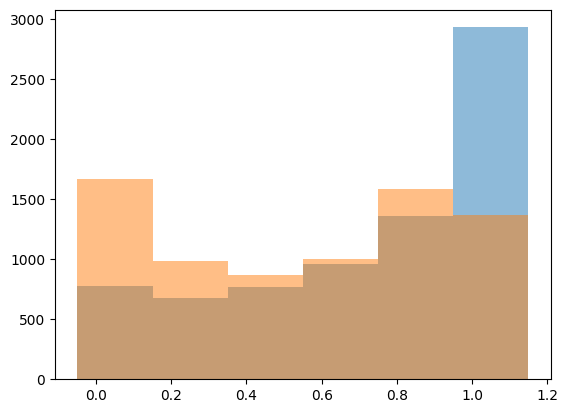

In [22]:
plt.hist(ratio_dict_new["unmemorized_acc_cummax_all"][-1], alpha=0.5, bins  =np.arange(0, 1.4, 0.2)-0.05)
plt.hist(ratio_dict["unmemorized_acc_cummax_all"][-1], alpha=0.5, bins  =np.arange(0, 1.4, 0.2)-0.05)
plt.savefig("delete.png")

In [30]:
(ratio_dict_new["unmemorized_acc_cummax_all"][-1]<0.5).mean()*7200*6


# 14169

12873.86591730229

In [6]:
orig_data_unmemorized_acc = np.load("gsm8k_unmemorized_acc_cummax_all.npy")

In [8]:
orig_data_unmemorized_acc.shape

(7473,)

In [11]:
ratio_dict_new["unmemorized_acc_cummax"][-1]

0.690400107052054

In [26]:
np.save("ckpts/gsm8k_amrith_3epochs_batch_1_all_lr2e-05_bs128/checkpoint-1224/unmemorized_acc_cummax_all.npy", ratio_dict_new["unmemorized_acc_cummax_all"][-1])

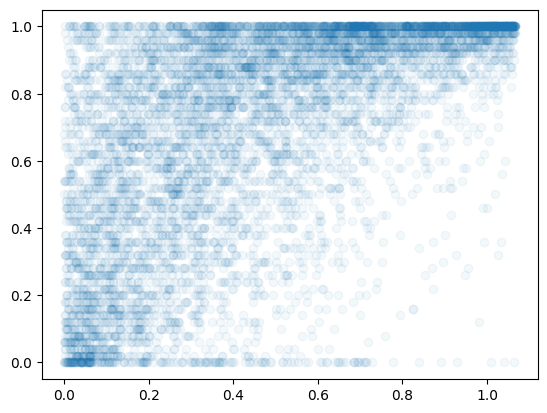

In [14]:
plt.scatter(orig_data_unmemorized_acc+np.random.uniform(0, 0.2/3, len(orig_data_unmemorized_acc)), ratio_dict_new["unmemorized_acc_cummax_all"][-1], label="New", alpha=0.05)

(array([0.95811588, 0.34256657, 0.55399438, 0.36665329, 0.52723137,
        0.58611   , 0.3934163 , 0.40679781, 0.60484411, 0.49243945,
        0.72527767, 0.74133547, 0.55131808, 0.88585575, 0.66639904,
        0.83232972, 1.37294259, 1.23109862, 2.30697177, 5.45430215]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

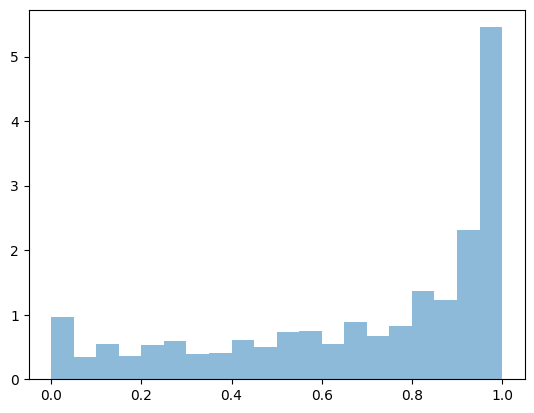

In [41]:
plt.hist(ratio_dict_new["unmemorized_acc_cummax_all"][-1], alpha=0.5, density=True, bins=20)
# idxs = np.where(orig_data_unmemorized_acc<0.25)[0]

# plt.hist(ratio_dict_new["unmemorized_acc_cummax_all"][-1][idxs], alpha=0.5, density=True, bins=20)
# idxs = np.where(orig_data_unmemorized_acc>=0.25)[0]
# plt.hist(ratio_dict_new["unmemorized_acc_cummax_all"][-1][idxs], alpha=0.5, density=True, bins=20)



In [47]:
len(np.where(ratio_dict_new["unmemorized_acc_cummax_all"][-1]<=0.6)[0])*12

30036

In [36]:
len(np.where(ratio_dict_new["unmemorized_acc_cummax_all"][-1]>=0.8)[0])*12

46476

In [31]:
7473*6

44838

In [21]:
(np.load("ckpts/gsm8k_amrith_3epochs_batch_1_threshold1_lr2e-05_bs128/checkpoint-1881/test_answer_types5_seed2_temp0.8.npy")==0).mean()

0.6850644427596664

In [23]:
(np.load("ckpts/gsm8k_amrith_3epochs_batch_1_all_lr2e-05_bs128/checkpoint-1224/test_answer_types5_seed2_temp0.8.npy")==0).mean()

0.6606520090978014

In [5]:
stats_dict = get_stats(f"gsm8k_amrith_3epochs_3copies_lr2e-05_bs128")
ratio_dict = get_ratios2(stats_dict, perp_threshold=-2.4)

In [8]:
np.save("ckpts/gsm8k_amrith_3epochs_3copies_lr2e-05_bs128/unmemorized_acc_cummax_all.npy", ratio_dict["unmemorized_acc_cummax_all"])

(array([ 816.,  639.,  768.,  887., 1295., 3068.]),
 array([-0.05,  0.15,  0.35,  0.55,  0.75,  0.95,  1.15]),
 <BarContainer object of 6 artists>)

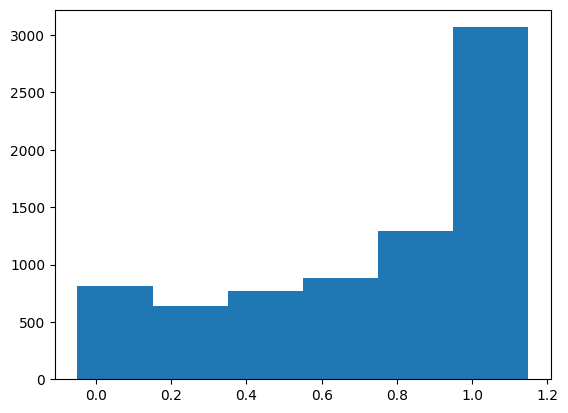

In [11]:
plt.hist(ratio_dict["unmemorized_acc_cummax_all"][-1], np.arange(0, 1.4, 0.2)-0.05)

In [17]:
(ratio_dict["unmemorized_acc_cummax_all"][-1]<0.5).mean()*9

2.6772380570052188

In [3]:

ratio_dicts4 = []
for i in range(6):
    stats_dict = get_stats(f"gsm8k_orig_3epochs_shuffle{i+1}_lr0.0002_bs128")
    ratio_dict = get_ratios2(stats_dict)
    ratio_dicts4.append(ratio_dict)

In [4]:

for i in range(6):
    unmemorized_acc_cummax = []
    for j in range(i+1):
        unmemorized_acc_cummax.append(ratio_dicts4[j]["unmemorized_acc_cummax_all"][-1])
    unmemorized_acc_cummax = np.array(unmemorized_acc_cummax)
    # print(np.max(unmemorized_acc_cummax, axis=0).mean())
    
    unmemorized_acc_cummax_max = []
    for k in range(7473):
        if np.std(unmemorized_acc_cummax[:, k])>0.2:
            unmemorized_acc_cummax_max.append(unmemorized_acc_cummax[:, k].mean())
        else:
            unmemorized_acc_cummax_max.append(unmemorized_acc_cummax[:, k].max())
        
    print(np.max(unmemorized_acc_cummax, axis=0).mean(), np.mean(unmemorized_acc_cummax_max))

0.26555332530442927 0.26555332530442927
0.38560417503010835 0.32054462732503686
0.45067576609126186 0.33712743654935545
0.4961809179713636 0.34303091128061025
0.5327338418305901 0.3537556536866051
0.5618734109460725 0.35884428386636336


In [5]:
unmemorized_acc_cummax4 = unmemorized_acc_cummax

In [3]:
ratio_dicts5 = []
for i in range(6):
    stats_dict = get_stats(f"gsm8k_orig_3epochs_shuffle{i+1}_lr2e-05_bs128")
    ratio_dict = get_ratios2(stats_dict)
    ratio_dicts5.append(ratio_dict)

In [5]:
ratio_dicts5

[{'unmemorized_acc_cummax': array([0.46929479, 0.52018466, 0.5452402 ]),
  'unmemorized_acc_cummax_all': array([[0.  , 0.16, 0.18, ..., 0.4 , 0.28, 0.54],
         [0.  , 0.28, 0.78, ..., 0.7 , 0.54, 0.7 ],
         [0.  , 0.34, 1.  , ..., 0.7 , 0.9 , 0.32]]),
  'avg_test_acc': array([0.45216073, 0.52964367, 0.54435178])},
 {'unmemorized_acc_cummax': array([0.43982604, 0.50396895, 0.52593604]),
  'unmemorized_acc_cummax_all': array([[1.  , 0.26, 0.06, ..., 0.32, 0.68, 0.08],
         [1.  , 0.26, 0.14, ..., 0.08, 0.3 , 0.08],
         [1.  , 0.26, 0.52, ..., 0.5 , 0.5 , 0.08]]),
  'avg_test_acc': array([0.43047763, 0.52706596, 0.55056861])},
 {'unmemorized_acc_cummax': array([0.43283019, 0.50619029, 0.52710023]),
  'unmemorized_acc_cummax_all': array([[0.  , 0.32, 0.6 , ..., 0.48, 0.26, 0.1 ],
         [0.  , 0.32, 0.6 , ..., 0.4 , 0.26, 0.16],
         [0.  , 0.32, 0.24, ..., 0.48, 0.26, 0.16]]),
  'avg_test_acc': array([0.41774071, 0.52236543, 0.55147839])},
 {'unmemorized_acc_cummax

In [4]:

for i in range(6):
    unmemorized_acc_cummax = []
    for j in range(i+1):
        unmemorized_acc_cummax.append(ratio_dicts5[j]["unmemorized_acc_cummax_all"][-1])
    unmemorized_acc_cummax = np.array(unmemorized_acc_cummax)
    
    unmemorized_acc_cummax_max = []
    for k in range(7473):
        if np.std(unmemorized_acc_cummax[:, k])>0.2:
            unmemorized_acc_cummax_max.append(unmemorized_acc_cummax[:, k].mean())
        else:
            unmemorized_acc_cummax_max.append(unmemorized_acc_cummax[:, k].max())
        
        # unmemorized_acc_cummax[:, k].mean()
        
    print(np.max(unmemorized_acc_cummax, axis=0).mean(), np.mean(unmemorized_acc_cummax_max))

0.5452401980463 0.5452401980463
0.6552201257861634 0.5872219991971096
0.7070627592666935 0.6006146572104019
0.7374601900173958 0.6059199785895892
0.7611401043757527 0.6109005754047906
0.7760738659173022 0.6120817164012667


In [10]:
np.save("ckpts/gsm8k_orig_3epochs_shuffle6_lr2e-05_bs128/unmemorized_acc_cummax_all.npy", ratio_dicts5[5]["unmemorized_acc_cummax_all"])

In [74]:
((ratio_dicts5[0]["unmemorized_acc_cummax_all"].max(axis=0)==0)).mean()

0.09219858156028368

(array([377., 261., 336., 287., 332., 296., 394., 314., 517., 622.]),
 array([0.22, 0.29, 0.36, 0.43, 0.5 , 0.57, 0.64, 0.71, 0.78, 0.85, 0.92]),
 <BarContainer object of 10 artists>)

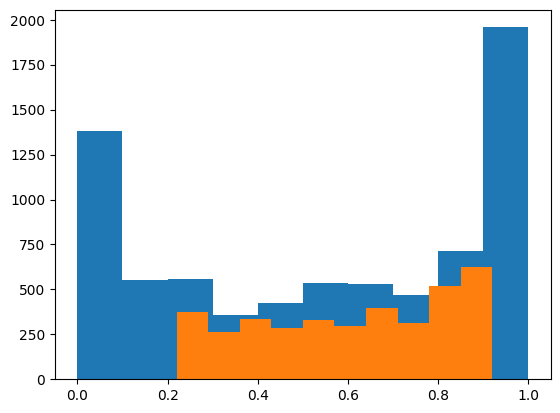

In [71]:
unmemorized_acc_cummax_all = ratio_dicts5[0]["unmemorized_acc_cummax_all"].max(axis=0)
sorted_idxs = np.argsort(unmemorized_acc_cummax_all) #lowest to highest
subsample_idxs = sorted_idxs[len(sorted_idxs)//4:-len(sorted_idxs)//4]
plt.hist(ratio_dicts5[-1]["unmemorized_acc_cummax_all"].max(axis=0))
plt.hist(unmemorized_acc_cummax_all[subsample_idxs])

(array([1380.,  552.,  556.,  357.,  426.,  533.,  528.,  468.,  715.,
        1958.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

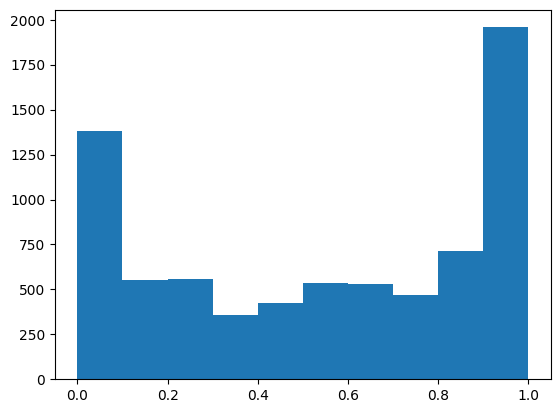

In [66]:
plt.hist(ratio_dicts5[-1]["unmemorized_acc_cummax_all"].max(axis=0))

In [54]:
(np.load("ckpts/math_orig_6epochs_full_lr5e-07_bs128/unmemorized_acc_cummax_full.npy").max(axis=0)> 0).mean()

0.5616

In [55]:
np.load("ckpts/math_orig_6epochs_full_lr5e-07_bs128/unmemorized_acc_cummax_full.npy")

array([[0. , 0.2, 0.8, ..., 0. , 0.4, 0. ],
       [0.2, 0.2, 0.8, ..., 0. , 0.4, 0. ],
       [0. , 0. , 0.4, ..., 0. , 0.4, 0. ],
       [0. , 0. , 1. , ..., 0. , 0.4, 0. ],
       [0. , 0. , 0.6, ..., 0. , 0.4, 0. ],
       [0.2, 0.4, 0.8, ..., 0. , 0.4, 0. ]])

In [8]:
unmemorized_acc_cummax5 = unmemorized_acc_cummax

In [11]:
unmemorized_acc_cummax_orig = np.load("gsm8k_unmemorized_acc_cummax_all.npy")

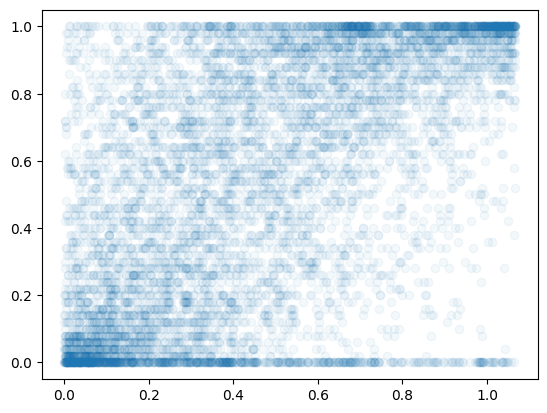

In [15]:
plt.scatter(unmemorized_acc_cummax_orig+np.random.uniform(0, 0.2/3, len(unmemorized_acc_cummax_orig)), unmemorized_acc_cummax5[-1], alpha=0.05)

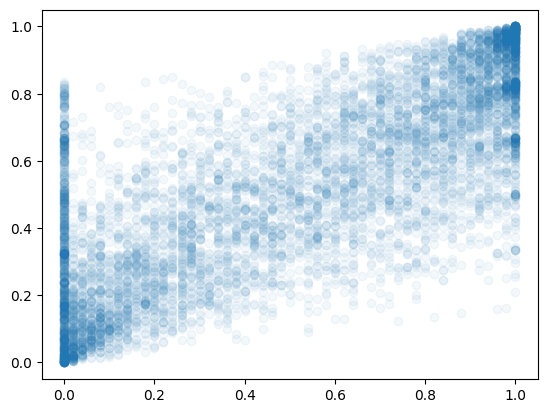

In [16]:
plt.scatter(unmemorized_acc_cummax5[-1],unmemorized_acc_cummax5.mean(axis=0), alpha=0.05)

In [ ]:

# can we predict which
# examples go from memroized in 2e-4 to unmemorized in 2e-5



# some examples get cutoff, some examples don't get cutoff



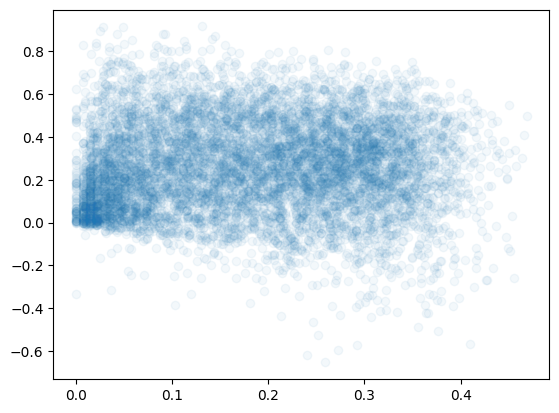

In [51]:
plt.scatter(np.std(unmemorized_acc_cummax4, axis=0), np.mean(unmemorized_acc_cummax5, axis=0)- np.mean(unmemorized_acc_cummax4, axis=0), alpha=0.05)


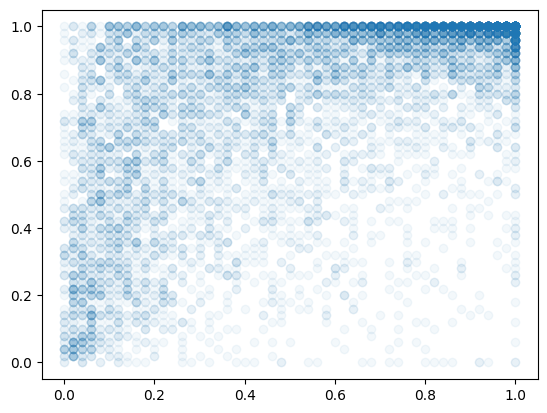

In [20]:
plt.scatter(np.max(unmemorized_acc_cummax4, axis=0), np.max(unmemorized_acc_cummax5, axis=0), alpha=0.05)


(array([[16., 16., 11., ...,  0.,  0.,  0.],
        [ 9., 15., 14., ...,  0.,  0.,  0.],
        [ 2.,  4.,  7., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  1.,  1.],
        [ 0.,  0.,  0., ...,  0.,  1.,  3.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.]]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
        0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
        0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
        0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
        0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
        0.99, 1.  ]),
 array([0.  , 0.01, 0.02, 0

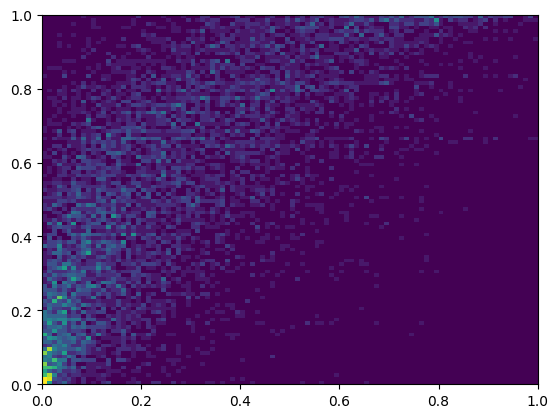

In [18]:
plt.hist2d(np.mean(unmemorized_acc_cummax4, axis=0), np.mean(unmemorized_acc_cummax5, axis=0), bins=(100, 100))


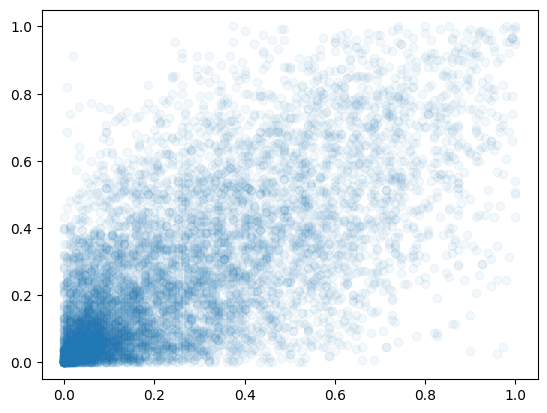

In [43]:
plt.scatter(np.mean(unmemorized_acc_cummax4[:3], axis=0), np.mean(unmemorized_acc_cummax4[3:], axis=0), alpha=0.05)


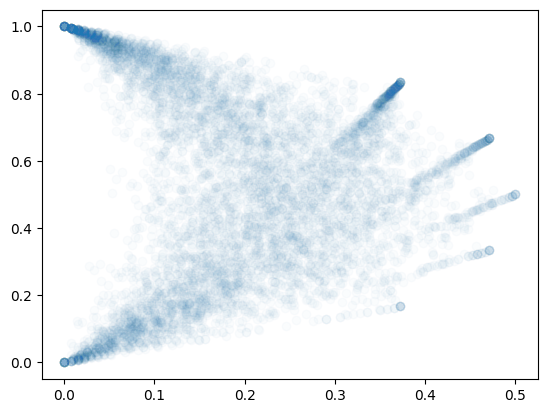

In [21]:
plt.scatter(np.std(unmemorized_acc_cummax5[:], axis=0), np.mean(unmemorized_acc_cummax5[:], axis=0), alpha=0.02)
# plt.scatter(np.std(unmemorized_acc_cummax4, axis=0), np.mean(unmemorized_acc_cummax4, axis=0), alpha=0.02)



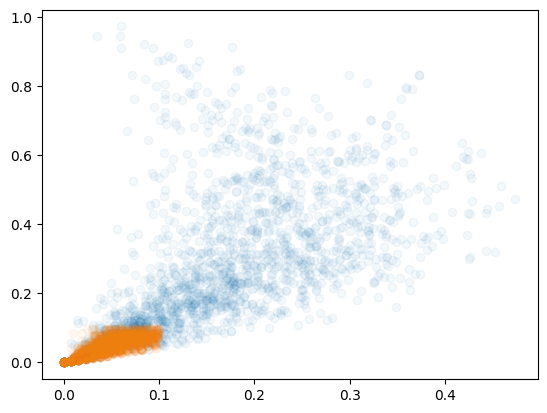

In [66]:
idxs = np.where((np.std(unmemorized_acc_cummax4[:], axis=0)<0.1)*(np.mean(unmemorized_acc_cummax4[:], axis=0)<0.1))[0]

plt.scatter(np.std(unmemorized_acc_cummax5[:], axis=0)[idxs], np.mean(unmemorized_acc_cummax5[:], axis=0)[idxs], alpha=0.05)
plt.scatter(np.std(unmemorized_acc_cummax4, axis=0)[idxs], np.mean(unmemorized_acc_cummax4, axis=0)[idxs], alpha=0.05)



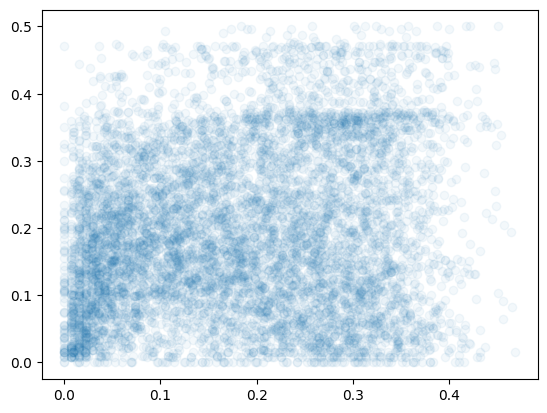

In [59]:
plt.scatter(np.std(unmemorized_acc_cummax4, axis=0), np.std(unmemorized_acc_cummax5, axis=0), alpha=0.05)


0.20631927212572376
0.2748852346694073
0.2898734634851771
0.28670588235294114
0.26943129520052594
0.2667180475272961
0.2533295497540673


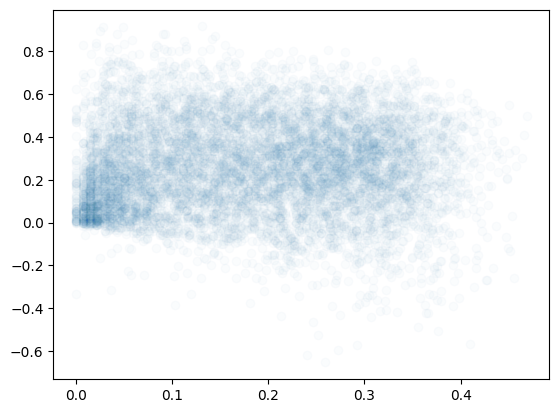

In [38]:
plt.scatter(np.std(unmemorized_acc_cummax4, axis=0), np.mean(unmemorized_acc_cummax5, axis=0)- np.mean(unmemorized_acc_cummax4, axis=0), alpha=0.02)


bins = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

for i in range(len(bins)-1):
    idxs = np.where((np.std(unmemorized_acc_cummax4, axis=0)>=bins[i])*(np.std(unmemorized_acc_cummax4, axis=0)<bins[i+1]))[0]
    print((np.mean(unmemorized_acc_cummax5, axis=0)- np.mean(unmemorized_acc_cummax4, axis=0))[idxs].mean())

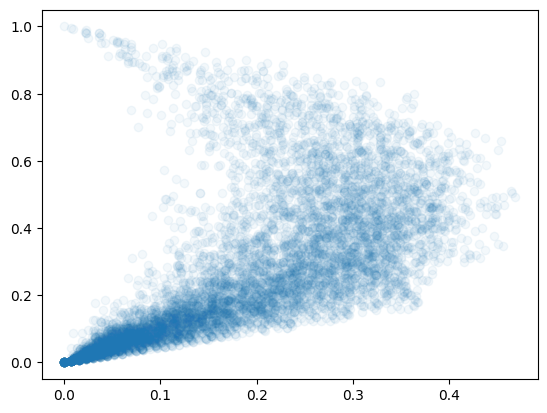

In [33]:
plt.scatter(np.std(unmemorized_acc_cummax4, axis=0), np.mean(unmemorized_acc_cummax4, axis=0), alpha=0.05)


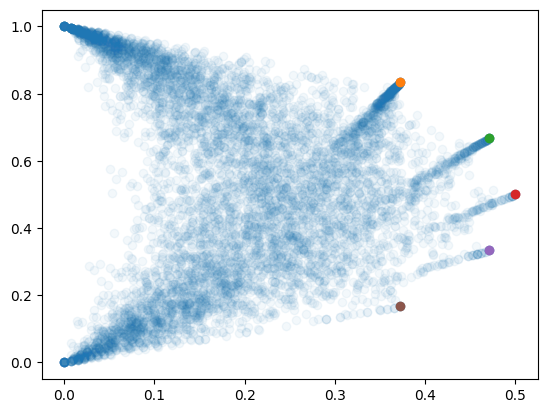

In [29]:
plt.scatter(np.std(unmemorized_acc_cummax5, axis=0), np.mean(unmemorized_acc_cummax5, axis=0), alpha=0.05)
# plt.scatter(np.std(unmemorized_acc_cummax5[:5], axis=0), unmemorized_acc_cummax5[5], alpha=0.05)

plt.scatter([np.std([1, 1, 1, 1, 1, 0])], np.mean([1, 1, 1, 1, 1, 0]))
plt.scatter([np.std([1, 1, 1, 1, 0, 0])], np.mean([1, 1, 1, 1, 0, 0]))
plt.scatter([np.std([1, 1, 1, 0, 0, 0])], np.mean([1, 1, 1, 0, 0, 0]))
plt.scatter([np.std([1, 1, 0, 0, 0, 0])], np.mean([1, 1, 0, 0, 0, 0]))
plt.scatter([np.std([1, 0, 0, 0, 0, 0])], np.mean([1, 0, 0, 0, 0, 0]))

In [24]:
np.std([1, 1, 1, 1, 1, 0])

0.37267799624996495

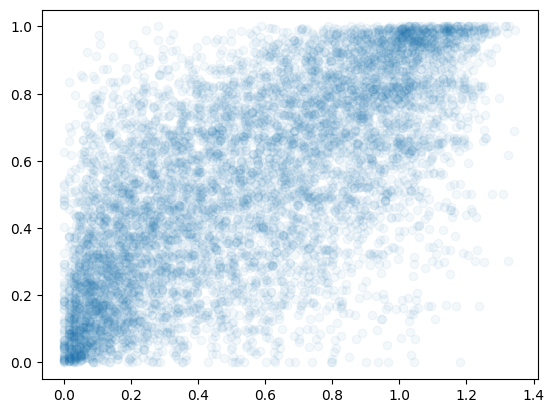

In [71]:
plt.scatter(np.mean(unmemorized_acc_cummax4, axis=0)+1.5*np.std(unmemorized_acc_cummax4, axis=0), np.mean(unmemorized_acc_cummax5, axis=0), alpha=0.05)

(array([ 878.,  998., 1179., 1100.,  939.,  732.,  706.,  543.,  212.,
         186.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <BarContainer object of 10 artists>)

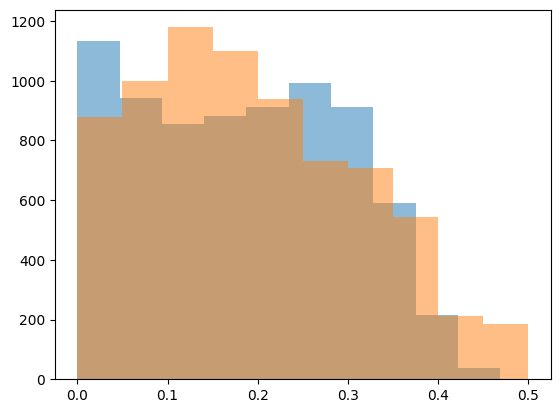

In [68]:
# plt.scatter(np.mean(unmemorized_acc_cummax4, axis=0), np.mean(unmemorized_acc_cummax5, axis=0), alpha=0.05)

plt.hist(np.std(unmemorized_acc_cummax4, axis=0), alpha=0.5)
plt.hist(np.std(unmemorized_acc_cummax5, axis=0), alpha=0.5)

In [12]:
unmemorized_acc_cummax4

array([[1.  , 0.24, 0.16, ..., 0.16, 0.72, 0.06],
       [0.48, 0.36, 0.  , ..., 0.04, 0.14, 0.04],
       [0.56, 0.1 , 0.06, ..., 0.04, 0.04, 0.02],
       [1.  , 0.42, 0.04, ..., 0.02, 0.06, 0.  ],
       [0.7 , 0.14, 0.14, ..., 0.02, 0.52, 0.  ],
       [0.  , 0.02, 0.12, ..., 0.1 , 0.  , 0.08]])

In [13]:
unmemorized_acc_cummax5

array([[0.  , 0.34, 1.  , ..., 0.7 , 0.9 , 0.32],
       [1.  , 0.26, 0.52, ..., 0.5 , 0.5 , 0.08],
       [0.  , 0.32, 0.24, ..., 0.48, 0.26, 0.16],
       [0.  , 0.86, 0.26, ..., 0.76, 0.34, 0.02],
       [1.  , 0.72, 0.54, ..., 0.78, 0.8 , 0.2 ],
       [0.  , 0.84, 1.  , ..., 0.9 , 0.64, 0.64]])

In [102]:
unmemorized_acc_cummax_max = []
for k in range(7473):
    if np.std(unmemorized_acc_cummax[:, k])>0.4:
        unmemorized_acc_cummax_max.append(unmemorized_acc_cummax[:, k].mean())
    else:
        unmemorized_acc_cummax_max.append(unmemorized_acc_cummax[:, k].max())

In [104]:
np.mean(unmemorized_acc_cummax_max)

0.7512021053570632

In [69]:
ratio_dicts5[1]["unmemorized_acc_cummax_all"][-1].shape

(7473,)

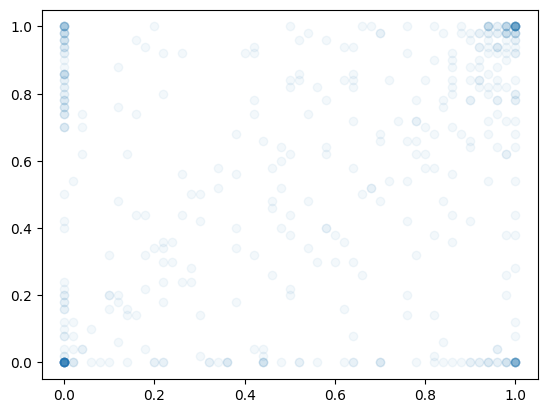

In [41]:

idxs = np.where((ratio_dicts5[1]["unmemorized_acc_cummax_all"][-1]==0)*(ratio_dicts5[2]["unmemorized_acc_cummax_all"][-1]>0.2))[0]

plt.scatter(ratio_dicts5[0]["unmemorized_acc_cummax_all"][-1][idxs], ratio_dicts5[5]["unmemorized_acc_cummax_all"][-1][idxs], alpha=0.05)


In [60]:
train_samples1 = (np.load("ckpts/"+"gsm8k_orig_3epochs_shuffle1_lr2e-05_bs128"+"/"+"checkpoint-58"+ "/train_answers50_seed2_temp0.8.npy"))
train_samples2 = (np.load("ckpts/"+"gsm8k_orig_3epochs_shuffle2_lr2e-05_bs128"+"/"+"checkpoint-58"+ "/train_answers50_seed2_temp0.8.npy"))


In [61]:
perp1 = (np.load("ckpts/"+"gsm8k_orig_3epochs_shuffle1_lr2e-05_bs128"+"/"+"checkpoint-58"+ "/train_perplexities.npy"))
perp2 = (np.load("ckpts/"+"gsm8k_orig_3epochs_shuffle2_lr2e-05_bs128"+"/"+"checkpoint-58"+ "/train_perplexities.npy"))


In [99]:

a = []
for i in range(6):
    print(ratio_dicts5[i]["unmemorized_acc_cummax_all"][-1][0])
    a.append(ratio_dicts5[i]["unmemorized_acc_cummax_all"][-1][0])
print(np.std(a))

0.0
1.0
0.0
0.0
1.0
0.0
0.4714045207910317


In [62]:
np.where((ratio_dicts5[1]["unmemorized_acc_cummax_all"][-1]==0)*(ratio_dicts5[2]["unmemorized_acc_cummax_all"][-1]>0.8))[0]

array([  34,   36,   38,   46,   70,   74,  102,  407,  448,  524,  542,
        552,  564,  565,  620,  628,  640,  662,  668,  712,  749,  767,
        796,  825,  841,  843,  887,  907,  917,  918,  934,  952, 1014,
       1025, 1036, 1049, 1061, 1209, 1289, 1316, 1389, 1390, 1404, 1406,
       1509, 1513, 1599, 1641, 1672, 1685, 1738, 1740, 1747, 1807, 1814,
       1871, 1947, 1953, 2037, 2060, 2118, 2181, 2238, 2283, 2343, 2377,
       2418, 2441, 2482, 2503, 2513, 2514, 2528, 2542, 2587, 2588, 2676,
       2699, 2772, 2803, 2828, 2832, 2870, 2885, 2893, 2896, 2911, 2916,
       3024, 3034, 3078, 3139, 3177, 3269, 3275, 3300, 3357, 3358, 3402,
       3456, 3459, 3463, 3475, 3558, 3585, 3608, 3649, 3724, 3788, 3804,
       3808, 3965, 4001, 4017, 4048, 4058, 4063, 4079, 4081, 4116, 4149,
       4154, 4164, 4195, 4298, 4305, 4353, 4354, 4389, 4463, 4474, 4481,
       4487, 4496, 4541, 4583, 4584, 4606, 4634, 4642, 4656, 4661, 4665,
       4705, 4708, 4714, 4745, 4746, 4773, 4791, 48

In [63]:
np.log(np.log(perp1[34]))

-1.248251995377264

In [64]:
np.log(np.log(perp2[34]))

-2.615787802916248

In [67]:
train_samples1[36]

array([' Lisa earned 60/2=$<<60/2=30>>30.\nTommy earned 30/2=$<<30/2=15>>15.\nLisa earned 30-15=$<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned $60/2 = $<<60/2=30>>30.\nTommy earned $30/2 = $<<30/2=15>>15.\nLisa earned $30 - $15 = $<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned $60/2 = $<<60/2=30>>30.\nTommy earned $30/2 = $<<30/2=15>>15.\nLisa earned $30 - $15 = $<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned $60/2 = $<<60/2=30>>30.\nTommy earned $30/2 = $<<30/2=15>>15.\nLisa earned $30 - $15 = $<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned $60/2=$<<60/2=30>>30.\nTommy earned $30/2=$<<30/2=15>>15.\nLisa earned $30-$15=$<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned 60/2 = <<60/2=30>>30 dollars.\nTommy earned 30/2 = <<30/2=15>>15 dollars.\nLisa earned 30-15 = <<30-15=15>>15 dollars more than Tommy.\n#### 15',
       ' Lisa earned 60/2 = <<60/2=30>>30 dollars.\nTommy earned 30/2 = <<30/2=15>>15 dollars

In [68]:
train_samples2[36]

array([' Lisa earned $60 / 2 = $<<60/2=30>>30.\nTommy earned $30 / 2 = $<<30/2=15>>15.\nLisa earned $30 - $15 = $<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned $60 / 2 = $<<60/2=30>>30.\nTommy earned $30 / 2 = $<<30/2=15>>15.\nLisa earned $30 - $15 = $<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned $60 / 2 = $<<60/2=30>>30.\nTommy earned $30 / 2 = $<<30/2=15>>15.\nLisa earned $30 - $15 = $<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned $60 / 2 = $<<60/2=30>>30.\nTommy earned $30 / 2 = $<<30/2=15>>15.\nLisa earned $30 - $15 = $<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned $60 / 2 = $<<60/2=30>>30.\nTommy earned $30 / 2 = $<<30/2=15>>15.\nLisa earned $30 - $15 = $<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned $60 / 2 = $<<60/2=30>>30.\nTommy earned $30 / 2 = $<<30/2=15>>15.\nLisa earned $30 - $15 = $<<30-15=15>>15 more than Tommy.\n#### 15',
       ' Lisa earned $60 / 2 = $<<60/2=30>>30.\nTommy earned $30

In [ ]:
idxs = np.where(ratio_dicts5["unmemorized_acc_cummax_all"][-1]>0.5)[0]
idxs2 = np.where(ratio_dict1_2["unmemorized_acc_cummax_all"][-1]<0.5)[0]

# plt.scatter(ratio_dict1["unmemorized_acc_cummax_all"][-1][idxs], ratio_dict2["unmemorized_acc_cummax_all"][-1][idxs], alpha=0.05)
plt.scatter(ratio_dict1["unmemorized_acc_cummax_all"][-1][idxs2], ratio_dict2["unmemorized_acc_cummax_all"][-1][idxs2], alpha=0.05)

In [22]:
stats_dict2 = get_stats("gsm8k_orig_3epochs_shuffle3_lr2e-05_bs128")
ratio_dict2_2 = get_ratios2(stats_dict2)

['checkpoint-58', 'checkpoint-116', 'checkpoint-174']
(3, 7473)
(3, 7473)


In [ ]:
stats_dict2 = get_stats("gsm8k_orig_3epochs_shuffle3_lr2e-05_bs128")
ratio_dict2_2 = get_ratios2(stats_dict2)

In [50]:
ratio_dict1["unmemorized_acc_cummax_all"][-1].mean()

0.5452401980463

In [38]:
np.max([ratio_dict1["unmemorized_acc_cummax_all"][-1], ratio_dict2["unmemorized_acc_cummax_all"][-1]], axis=0).mean()

0.65479459387127

In [51]:
a = ratio_dict2["unmemorized_acc_cummax_all"][-1]
np.random.shuffle(a)

np.max([ratio_dict1["unmemorized_acc_cummax_all"][-1], a], axis=0).mean()

0.7436023016191623

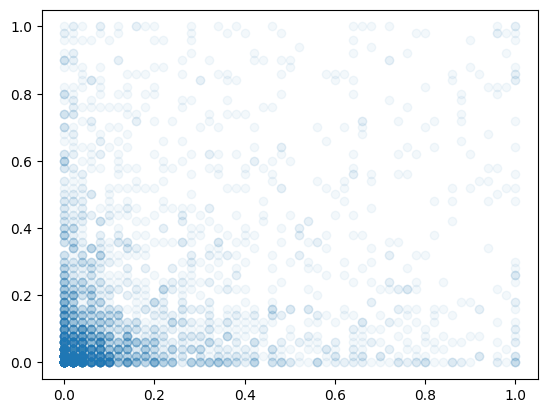

In [72]:
idxs = np.where(ratio_dict1_2["unmemorized_acc_cummax_all"][-1]>0.5)[0]
idxs2 = np.where(ratio_dict1_2["unmemorized_acc_cummax_all"][-1]<0.5)[0]

# plt.scatter(ratio_dict1["unmemorized_acc_cummax_all"][-1][idxs], ratio_dict2["unmemorized_acc_cummax_all"][-1][idxs], alpha=0.05)
plt.scatter(ratio_dict1["unmemorized_acc_cummax_all"][-1][idxs2], ratio_dict2["unmemorized_acc_cummax_all"][-1][idxs2], alpha=0.05)

(array([2030.,  409.,  257.,  133.,  110.,   82.,   75.,   56.,   46.,
          78.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

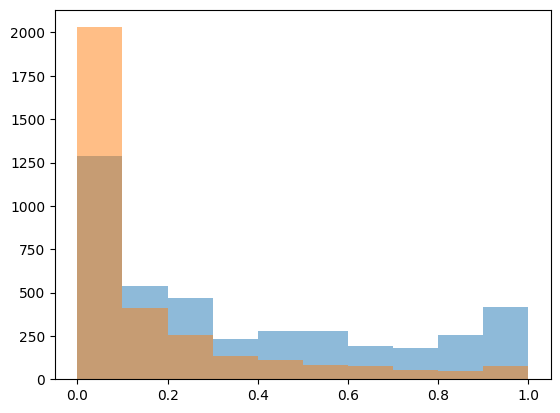

In [73]:
idxs = np.where(ratio_dict1_2["unmemorized_acc_cummax_all"][-1]>0.5)[0]
idxs2 = np.where(ratio_dict1_2["unmemorized_acc_cummax_all"][-1]<0.5)[0]

plt.hist(ratio_dict1["unmemorized_acc_cummax_all"][-1][idxs], alpha=0.5)
plt.hist(ratio_dict1["unmemorized_acc_cummax_all"][-1][idxs2], alpha=0.5)

(array([876., 591., 440., 227., 234., 209., 162., 137., 144., 256.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

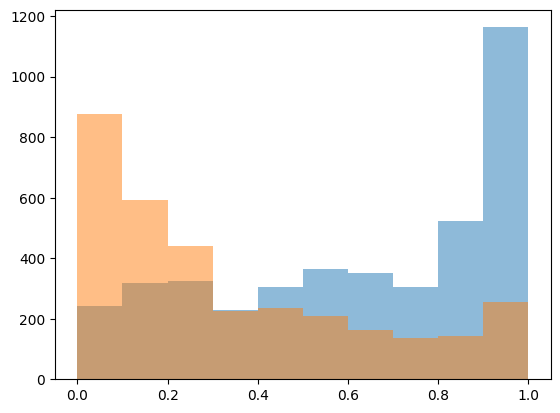

In [75]:
idxs = np.where(ratio_dict1_2["unmemorized_acc_cummax_all"][-1]>0.5)[0]
idxs2 = np.where(ratio_dict1_2["unmemorized_acc_cummax_all"][-1]<0.5)[0]


max_array = np.max([ratio_dict1["unmemorized_acc_cummax_all"][-1], ratio_dict2["unmemorized_acc_cummax_all"][-1], ratio_dict3["unmemorized_acc_cummax_all"][-1], ratio_dict4["unmemorized_acc_cummax_all"][-1]], axis=0)
plt.hist(max_array[idxs], alpha=0.5)
plt.hist(max_array[idxs2], alpha=0.5)

(array([927., 652., 476., 239., 242., 236., 152., 121., 166., 252.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

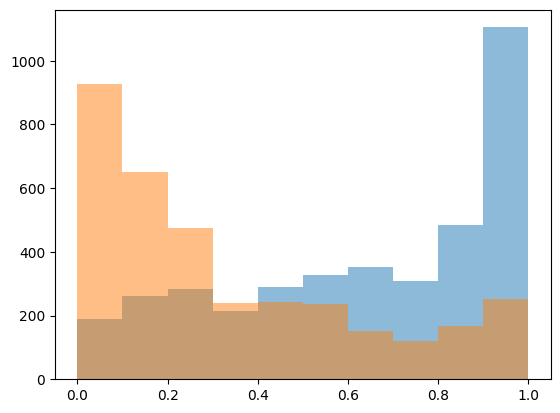

In [76]:
idxs = np.where((ratio_dict1_2["unmemorized_acc_cummax_all"][-1]+ratio_dict2_2["unmemorized_acc_cummax_all"][-1])/2>0.5)[0]
idxs2 = np.where((ratio_dict1_2["unmemorized_acc_cummax_all"][-1]+ratio_dict2_2["unmemorized_acc_cummax_all"][-1])/2<0.5)[0]


max_array = np.max([ratio_dict1["unmemorized_acc_cummax_all"][-1], ratio_dict2["unmemorized_acc_cummax_all"][-1], ratio_dict3["unmemorized_acc_cummax_all"][-1], ratio_dict4["unmemorized_acc_cummax_all"][-1]], axis=0)
plt.hist(max_array[idxs], alpha=0.5)
plt.hist(max_array[idxs2], alpha=0.5)

In [ ]:
plt.scatter(ratio_dict1["unmemorized_acc_cummax_all"][-1], ratio_dict1_2["unmemorized_acc_cummax_all"][-1], alpha=0.05)